# Notebook for relocation
References: 
- https://github.com/kaiwenwang233/scoped_ML_tutorial?tab=readme-ov-file
- https://www.usgs.gov/software/hypoinverse-earthquake-location
- https://chatgpt.com/c/67491af9-aaf8-800c-82e9-1033e094d8d0
- https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2017JB014966

In [2]:
from datetime import datetime
import pandas as pd
import os 
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import obspy
import pygmt
from obspy.geodetics import degrees2kilometers
from pathlib import Path



## Run HypoInverse

In [41]:
%cd /home/hbito/cascadia_obs_ensemble/workflow_pnsn_jdf
!hyp1.40 < ../hypoInv/hyp_elevation_pnsn_jdf.command

/home/hbito/cascadia_obs_ensemble/workflow_pnsn_jdf
 HYPOINVERSE 2000 STARTING
6/2014 VERSION 1.40 (geoid depth possible)                            
 COMMAND?  COMMAND?  COMMAND?  COMMAND?  COMMAND?  COMMAND?  COMMAND?  COMMAND?  COMMAND?  COMMAND?  COMMAND?  COMMAND?  COMMAND?  COMMAND?  COMMAND?     80 STATIONS READ IN.
 COMMAND?  COMMAND?   Read in crustal model(s):
 COMMAND?  COMMAND?  COMMAND?  COMMAND?  COMMAND?  COMMAND?  COMMAND?  COMMAND?  COMMAND?   FIND INPUT PHASE FILE TYPE & SET PHS(COP) & ARC(CAR) FORMATS
  INPUT IS A HYPOINVERSE ARCHIVE-2000 FILE, NO SHADOWS
  SETTING FORMATS COP 3, CAR 1
 COMMAND?  COMMAND?  COMMAND?  COMMAND?  COMMAND?  COMMAND?  COMMAND?   SEQ ---DATE--- TIME REMARK -LAT-  --LON-  DEPTH  RMS PMAG  NUM  ERH  ERZ  ID
    1 2011-12-10 22:44     - 45  6  125 52  13.33 0.29  0.0    5  6.8 24.2         0
 *** 3 PHASES CANT SOLVE SEQUENCE NO.    2, ID NO.         0
 *** ABANDON EVENT WITH ONLY 3 READINGS:2011 12 26 18  6
 *** STOP ITERATING EVENT 2012  2  4

## Plot the relocated events by HypoInverse

### Load the output file from HypoInverse

In [42]:
region = 'pnsn_jdf'
events_hpy = pd.read_csv(f'../hypoInv/catOut_{region}.sum', names=[ "lines" ])

events_hpy['YRMODY']=events_hpy['lines'].apply(lambda x: x[0:8])
events_hpy['HR']=events_hpy['lines'].apply(lambda x: x[8:10])
events_hpy['MIN']=events_hpy['lines'].apply(lambda x: x[10:12])
events_hpy['SEC']=events_hpy['lines'].apply(lambda x: x[12:16])
events_hpy['LAT']=events_hpy['lines'].apply(lambda x: float(x[16:18])+float(x[19:23])/6000)
events_hpy['LON']=events_hpy['lines'].apply(lambda x: float(x[23:26])+float(x[27:31])/6000)
events_hpy['DEPTH']=events_hpy['lines'].apply(lambda x: float(x[32:36])/100)
events_hpy['RMS']=events_hpy['lines'].apply(lambda x: float(x[48:52])/100)
# events_hpy = events_hpy[events_hpy['RMS']<0.1]
print(len(events_hpy))

23256


In [43]:
events_hpy

lines    YRMODY  HR MIN  \
0      201112102244468945  611125W5210 1359  0  5331 ...  20111210  22  44   
1      201202042005311348 4884128W 632 4986  0  73401...  20120204  20  05   
2      201202060817123343 2322126W 328  143  0  63572...  20120206  08  17   
3      201203181848439746 4440123W 824 2558  0  83112...  20120318  18  48   
4      201205280726276048 1525125W4274  480  0  6336 ...  20120528  07  26   
...                                                  ...       ...  ..  ..   
23251  201509140533011541 1043126W1293   34  0 10138 ...  20150914  05  33   
23252  201509140609077540 2915127W 986 5593  0 10289 ...  20150914  06  09   
23253  201509141334019040 3767127W1895 4786  0  8280 ...  20150914  13  34   
23254  201509150912529641 5883127W1477  596  0  6308 ...  20150915  09  12   
23255  201509151731033240 2039124W4431 5331  0  6344 ...  20150915  17  31   

        SEC        LAT         LON  DEPTH   RMS  
0      4689  45.101833  125.868333  13.59  0.29  
1      3113  48.814000  128.105333  49.86  0.82  
2      1233  43.387000  126.054667   1.43  1.29  
3      4397  46.740000  123.137333  25.58  0.60  
4      2760  48.254167  125.712333   4.80  0.48  
...     ...        ...         ...    ...   ...  
23251  0115  41.173833  126.215500   0.34  0.56  
23252  0775  40.485833  127.164333  55.93  0.58  
23253  0190  40.627833  127.315833  47.86  0.45  
23254  5296  41.980500  127.246167   5.96  0.28  
23255  0332  40.339833  124.738500  53.31  0.02  

[23256 rows x 9 columns]

In [44]:
events_hpy.to_csv(f'../data/datasets_{region}/events_hypoinv_{region}.csv', sep="\t", index=False,
                    columns=["YRMODY", "HR", "MIN", "SEC", "LAT", "LON", "DEPTH", "RMS"])

In [45]:
# Define config 
# GMMAResultDir='./GMMA'
# Path(GMMAResultDir).mkdir(parents=True, exist_ok=True)

# catalog_csv = GMMAResultDir+"/catalog_gamma.csv"
# picks_csv = GMMAResultDir+"/picks_gamma.csv"
# Load stations 

stations = pd.read_csv(f"./stations_{region}.csv", sep="\t")

region_name = "Offshore Washington, Oregon and Northern California"
center = (-125.5, 46.0)
horizontal_degree = 9
vertical_degree = 12
starttime = obspy.UTCDateTime("2011-01-01T00")
endtime =   obspy.UTCDateTime("2015-12-31T23")
network_list = list(pd.read_csv("../data/networks.csv")["networks"])
channel_list = "HH*,BH*" # change if needed

config = {}
config["region"] = region_name
config["center"] = center
config["xlim_degree"] = [center[0] - horizontal_degree / 2, center[0] + horizontal_degree / 2]
config["ylim_degree"] = [center[1] - vertical_degree / 2, center[1] + vertical_degree / 2]
config["starttime"] = starttime.datetime.isoformat()
config["endtime"] = endtime.datetime.isoformat()
config["networks"] = network_list
config["channels"] = channel_list
config["degree2km"] = 111
config["degree2km_x"] = 82
config['vel']= {"p":6.2, "s":3.3}


config["dims"] = ['x(km)', 'y(km)', 'z(km)']
config["use_dbscan"] = True
config["use_amplitude"] = True
config["x(km)"] = (np.array(config["xlim_degree"])-np.array(config["center"][0]))*config["degree2km_x"]
config["y(km)"] = (np.array(config["ylim_degree"])-np.array(config["center"][1]))*config["degree2km"]
config["z(km)"] = (0, 20)

# DBSCAN
config["bfgs_bounds"] = ((config["x(km)"][0]-1, config["x(km)"][1]+1), #x
                        (config["y(km)"][0]-1, config["y(km)"][1]+1), #y
                        (0, config["z(km)"][1]+1), #x
                        (None, None)) #t
config["dbscan_eps"] = 6
config["dbscan_min_samples"] = min(len(stations), 3)
config["min_picks_per_eq"] = min(len(stations)//2+1, 10)

config["method"] = "BGMM"
if config["method"] == "BGMM":
    config["oversample_factor"] = 4
if config["method"] == "GMM":
    config["oversample_factor"] = 1

config["max_sigma11"] = 2.0
config["max_sigma22"] = 1.0
config["max_sigma12"] = 1.0

for k, v in config.items():
    print(f"{k}: {v}")

region: Offshore Washington, Oregon and Northern California
center: (-125.5, 46.0)
xlim_degree: [-130.0, -121.0]
ylim_degree: [40.0, 52.0]
starttime: 2011-01-01T00:00:00
endtime: 2015-12-31T23:00:00
networks: ['C8', '7D', '7A', 'CN', 'NV', 'UW', 'UO', 'NC', 'BK', 'TA', 'OO', 'PB', 'X6', 'Z5', 'X9']
channels: HH*,BH*
degree2km: 111
degree2km_x: 82
vel: {'p': 6.2, 's': 3.3}
dims: ['x(km)', 'y(km)', 'z(km)']
use_dbscan: True
use_amplitude: True
x(km): [-369.  369.]
y(km): [-666.  666.]
z(km): (0, 20)
bfgs_bounds: ((-370.0, 370.0), (-667.0, 667.0), (0, 21), (None, None))
dbscan_eps: 6
dbscan_min_samples: 3
min_picks_per_eq: 10
method: BGMM
oversample_factor: 4
max_sigma11: 2.0
max_sigma22: 1.0
max_sigma12: 1.0


### Plot the events 

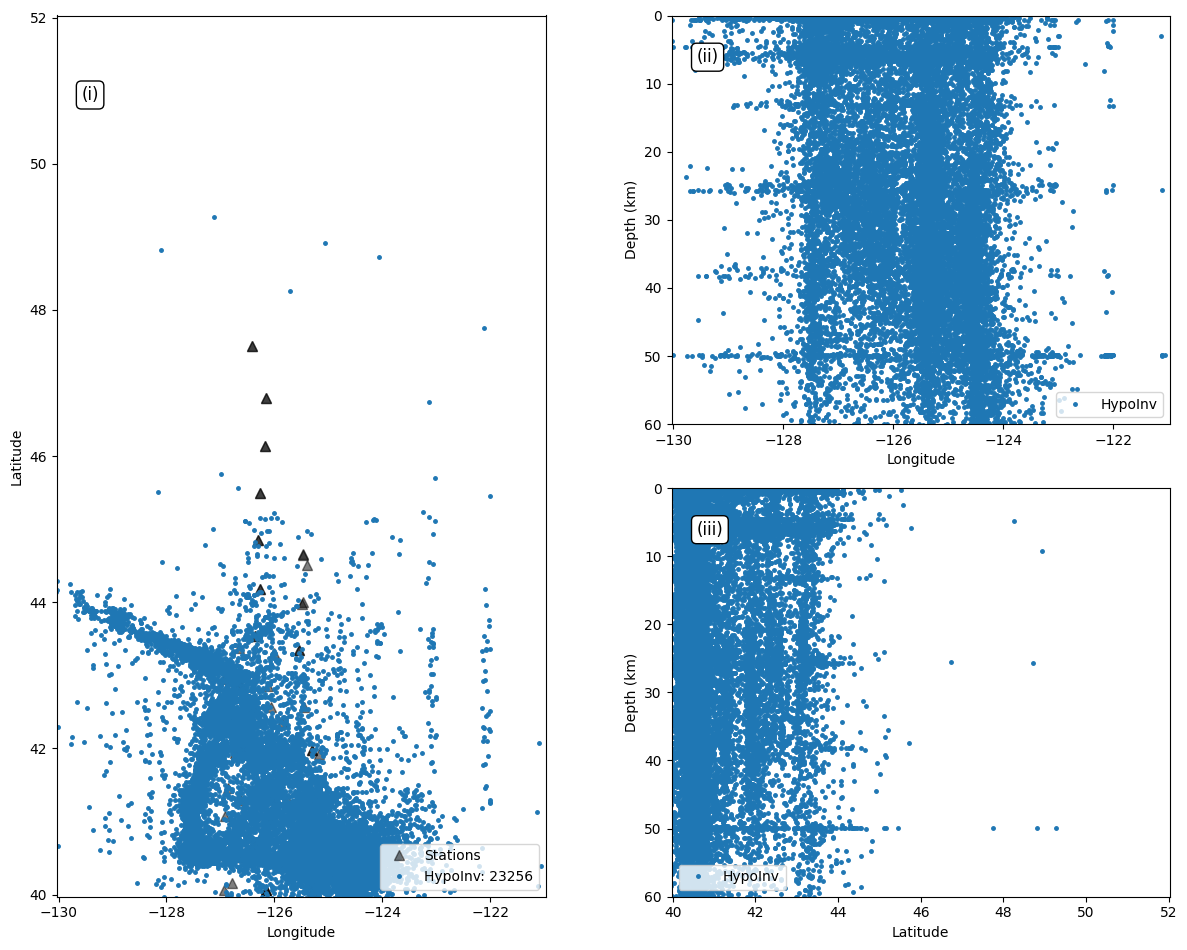

In [46]:
# Load stations 
stations = pd.read_csv(f"./stations_{region}.csv", sep="\t")

# Plot the events 
marker_size=5
hyp_label="HypoInv"
fig = plt.figure(figsize=plt.rcParams["figure.figsize"]*np.array([2,2]))
box = dict(boxstyle='round', facecolor='white', alpha=1)
text_loc = [0.05, 0.92]
grd = fig.add_gridspec(ncols=2, nrows=2, width_ratios=[1.5, 1], height_ratios=[1,1])
fig.add_subplot(grd[:, 0])
plt.plot(stations["longitude"], stations["latitude"], 'k^', markersize=1.5*marker_size, alpha=0.5, label="Stations")
plt.plot(events_hpy["LON"]*(-1), events_hpy["LAT"], '.',markersize=marker_size, alpha=1.0, rasterized=True, label=f"{hyp_label}: {len(events_hpy)}")

plt.gca().set_aspect(111/82)
plt.xlim(np.array(config["xlim_degree"])+np.array([-0.03,0.03]))
plt.ylim(np.array(config["ylim_degree"])+np.array([-0.03,0.03]))
plt.ylabel("Latitude")
plt.xlabel("Longitude")
plt.gca().set_prop_cycle(None)
plt.plot(config["xlim_degree"][0]-10, config["ylim_degree"][0]-10, '.', markersize=10)
plt.legend(loc="lower right")
plt.text(text_loc[0], text_loc[1], '(i)', horizontalalignment='left', verticalalignment="top",
         transform=plt.gca().transAxes, fontsize="large", fontweight="normal", bbox=box)

fig.add_subplot(grd[0, 1])
plt.plot(events_hpy["LON"]*(-1), events_hpy["DEPTH"], '.', markersize=marker_size, alpha=1.0, rasterized=True,label=f"{hyp_label}")

plt.xlim(np.array(config["xlim_degree"])+np.array([-0.03,0.03]))
plt.ylim(bottom=0, top=60)
plt.gca().invert_yaxis()
plt.xlabel("Longitude")
plt.ylabel("Depth (km)")
plt.gca().set_prop_cycle(None)
plt.plot(config["xlim_degree"][0]-10, 31, '.', markersize=10)
plt.legend(loc="lower right")
plt.text(text_loc[0], text_loc[1], '(ii)', horizontalalignment='left', verticalalignment="top",
         transform=plt.gca().transAxes, fontsize="large", fontweight="normal", bbox=box)


fig.add_subplot(grd[1, 1])
plt.plot(events_hpy["LAT"], events_hpy["DEPTH"], '.', markersize=marker_size, alpha=1.0, rasterized=True,label=f"{hyp_label}")

plt.xlim(np.array(config["ylim_degree"])+np.array([-0.03,0.03]))
plt.ylim(bottom=0, top=60)
plt.gca().invert_yaxis()
plt.xlabel("Latitude")
plt.ylabel("Depth (km)")
plt.gca().set_prop_cycle(None)
plt.plot(config["ylim_degree"][0]-10, 31, '.', markersize=10)
plt.legend(loc="lower left")
plt.tight_layout()
plt.text(text_loc[0], text_loc[1], '(iii)', horizontalalignment='left', verticalalignment="top",
         transform=plt.gca().transAxes, fontsize="large", fontweight="normal", bbox=box)

plt.savefig(f"relocated_events_profile_hypoinv_{region}.pdf")


plt.show()

### Make a plot with topography

events_hpy columns: Index(['lines', 'YRMODY', 'HR', 'MIN', 'SEC', 'LAT', 'LON', 'DEPTH', 'RMS'], dtype='object')
stations columns: Index(['Unnamed: 0', 'station', 'longitude', 'latitude', 'elevation(m)',
       'component', 'response', 'unit', 'id'],
      dtype='object')
Length of events_hpy['LON']: 23256
Length of events_hpy['LAT']: 23256
Length of stations['longitude']: 80
Length of stations['latitude']: 80


/tmp/ipykernel_2555125/253012249.py:41: FutureWarning: The 'color' parameter has been deprecated since v0.8.0 and will be removed in v0.12.0. Please use 'fill' instead.
  fig.plot(


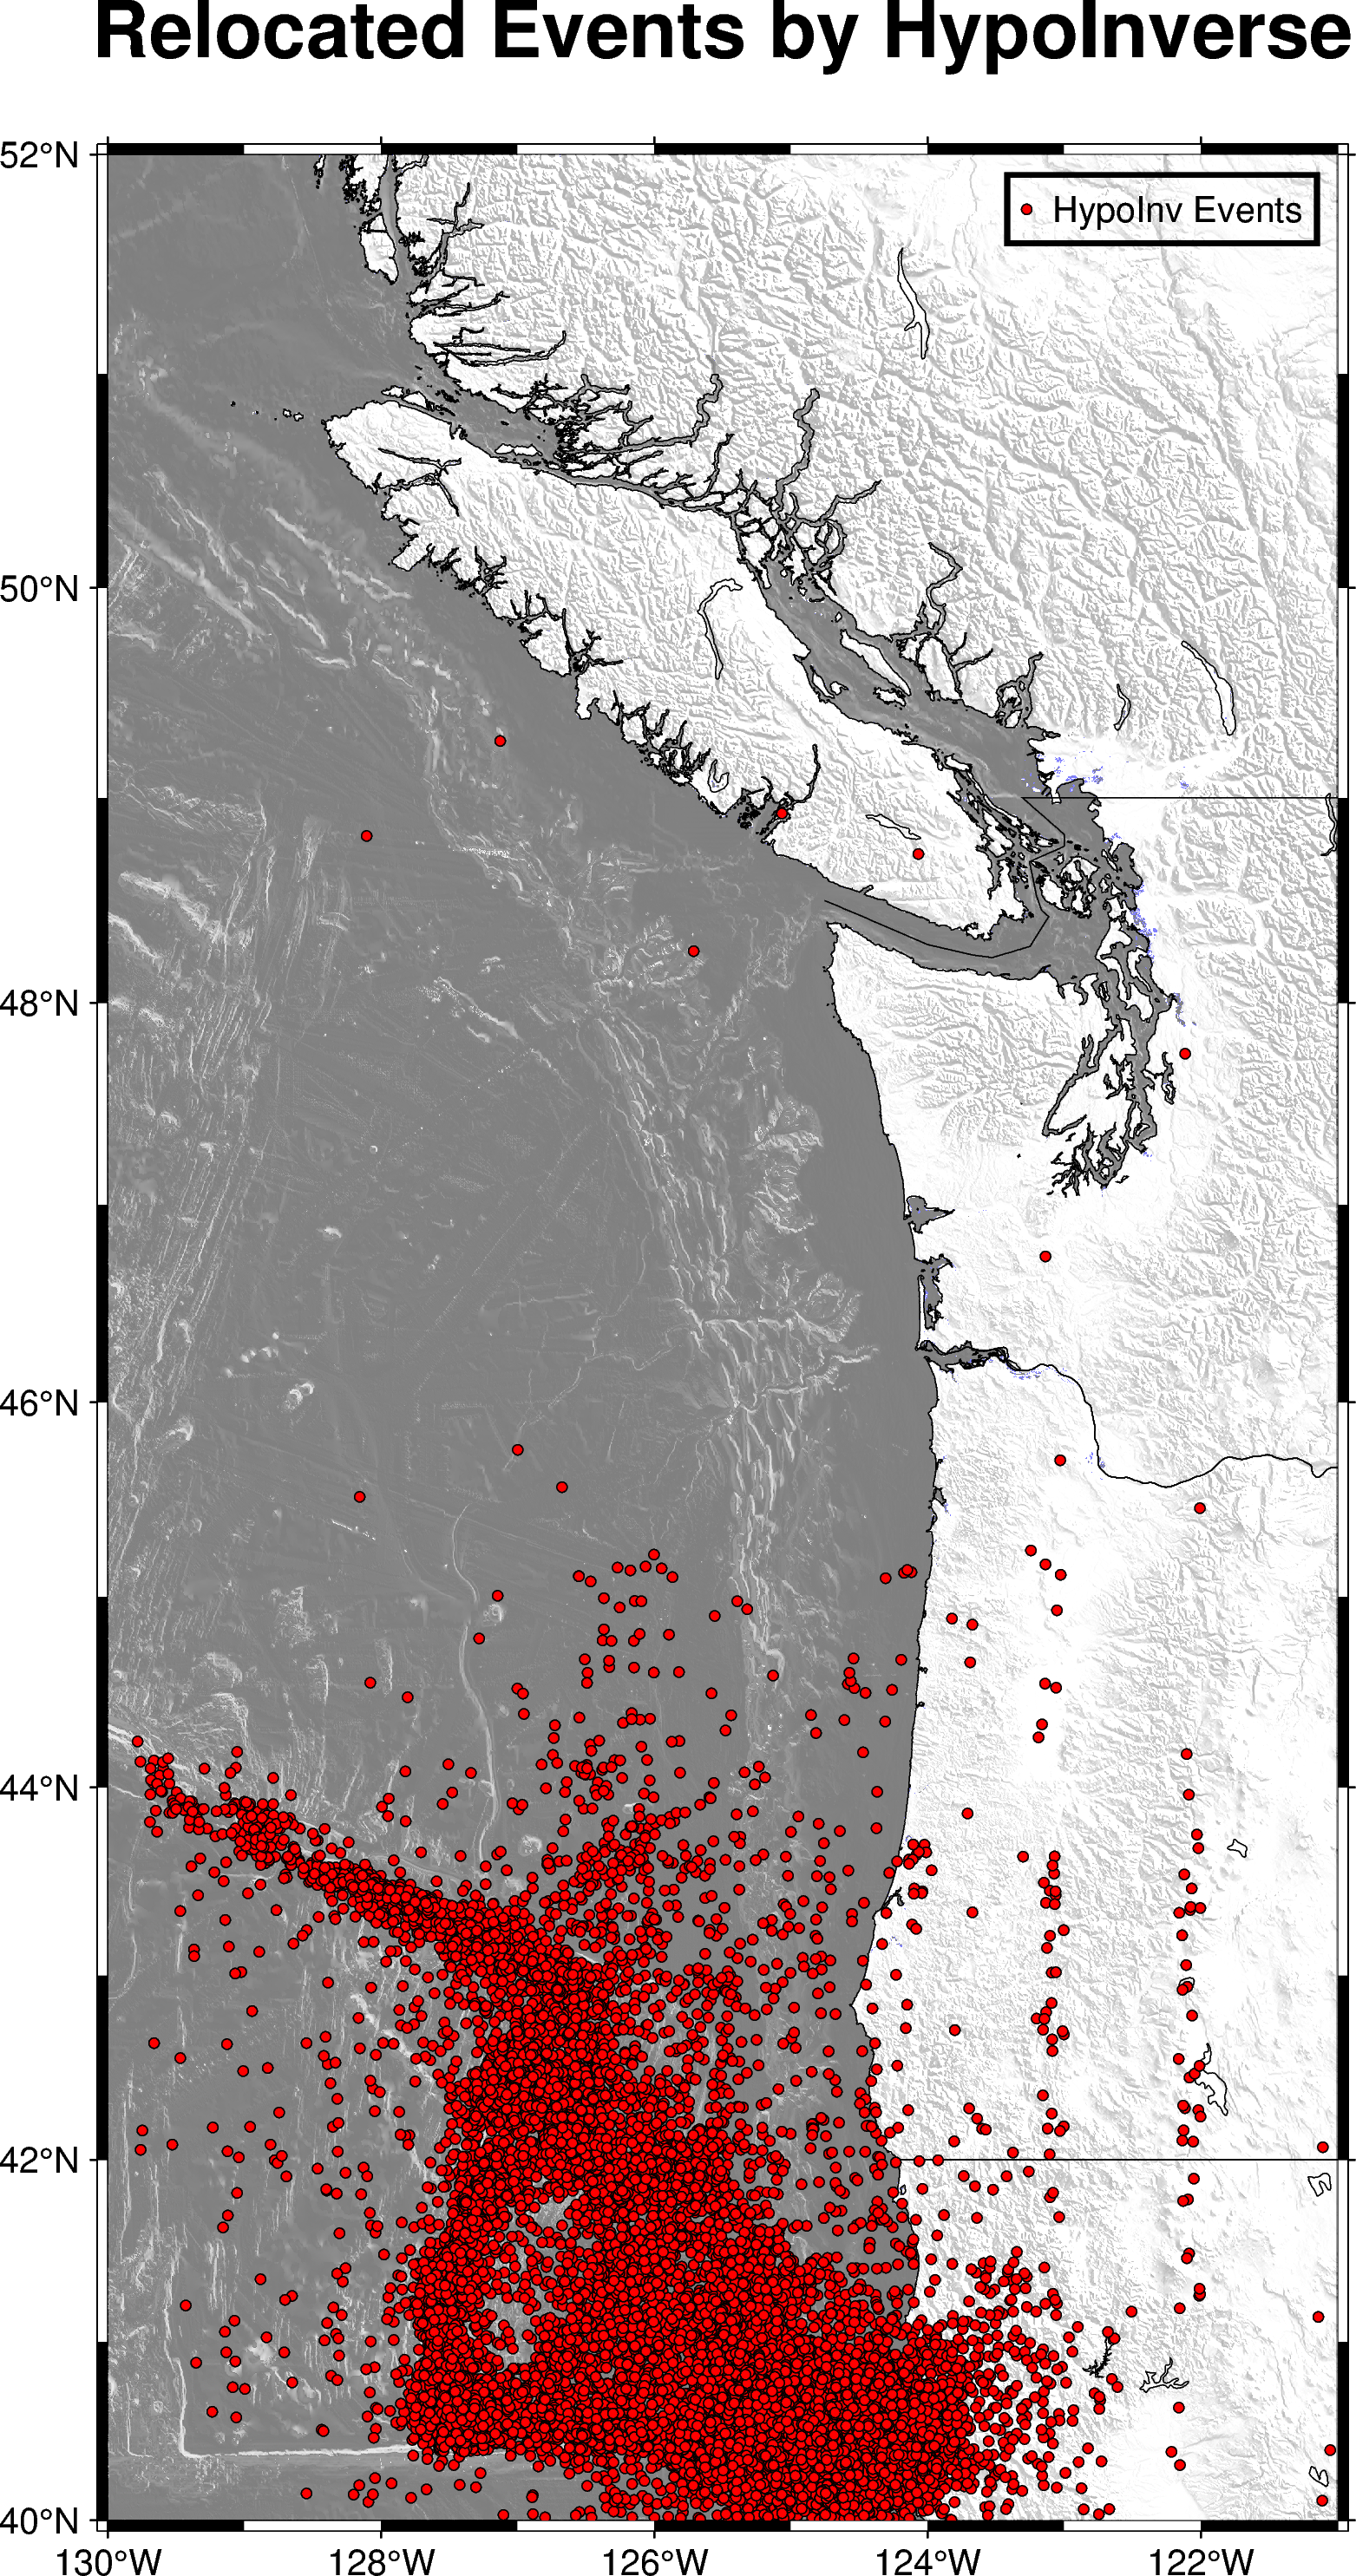

In [47]:
# Parameters

region_id = region 

# Define target region
min_lat = 40
max_lat = 52
min_lon = -130
max_lon = -121

# Plotting parameters
transparency = 60

# Initialize the figure
fig = pygmt.Figure()

# Load grid data
grid = pygmt.datasets.load_earth_relief(resolution="15s", region=[min_lon, max_lon, min_lat, max_lat])
shade = pygmt.grdgradient(grid=grid, azimuth="0/90", normalize="t1")

# Define target region
region = [min_lon, max_lon, min_lat, max_lat]
title = "Relocated Events by HypoInverse"
fig.basemap(region=region, projection="M12c", frame=["af", f"WSne+t{title}"])

fig.grdimage(grid=grid, cmap="blue", shading=shade, transparency=50)
fig.coast(region=region, projection="M12c", shorelines=True, borders=[1, 2], resolution="f")


# Debugging: Print the columns of the DataFrames
print("events_hpy columns:", events_hpy.columns)
print("stations columns:", stations.columns)

# Debugging: Print the lengths of the columns
print("Length of events_hpy['LON']:", len(events_hpy['LON']))
print("Length of events_hpy['LAT']:", len(events_hpy['LAT']))
print("Length of stations['longitude']:", len(stations['longitude']))
print("Length of stations['latitude']:", len(stations['latitude']))

# Plotting data points with dynamic transparency and sizes
fig.plot(
    x=events_hpy['LON']*(-1),
    y=events_hpy["LAT"],
    style="c0.1c",  # Circle with size 0.1 cm
    color='red',
    pen="black",
    label='HypoInv Events'
)

# Plot stations
# fig.plot(
#     x=stations['longitude'],
#     y=stations['latitude'],
#     style="t0.2c",  # Triangle with size 0.2 cm
#     pen="black",
#     fill = "gray",
#     label="Stations"
# )

fig.legend(position="jTR+o0.2c", box=True)

# Save and display the figure
fig.savefig(f"relocated_events_hypoinv_{region_id}.pdf")
fig.show()

### Plot a cross section

121.10633333333334 121.10633333333334 0.0
122.00233333333334 121.10633333333334 99.63065427352471
122.018 121.10633333333334 101.37270812428883
122.04533333333333 121.10633333333334 104.41203611923987
122.052 121.10633333333334 105.1533356302045
122.05666666666667 121.10633333333334 105.67224528787895
122.08366666666667 121.10633333333334 108.67450830728215
122.095 121.10633333333334 109.93471747591965
122.11666666666666 121.10633333333334 112.34394088655115
122.12633333333333 121.10633333333334 113.41882517744946
122.12933333333334 121.10633333333334 113.75240995738315
122.12966666666667 121.10633333333334 113.78947493293099
122.135 121.10633333333334 114.38251454170269
123.00433333333334 121.10633333333334 211.04797077137204
123.03133333333334 121.10633333333334 214.05023379077525
123.037 121.10633333333334 214.68033837509478
123.08133333333333 121.10633333333334 219.60998012300286
123.09166666666667 121.10633333333334 220.75899436499685
123.104 121.10633333333334 222.13039846027945


Text(0.5, 1.0, 'Cross Section at 42°')

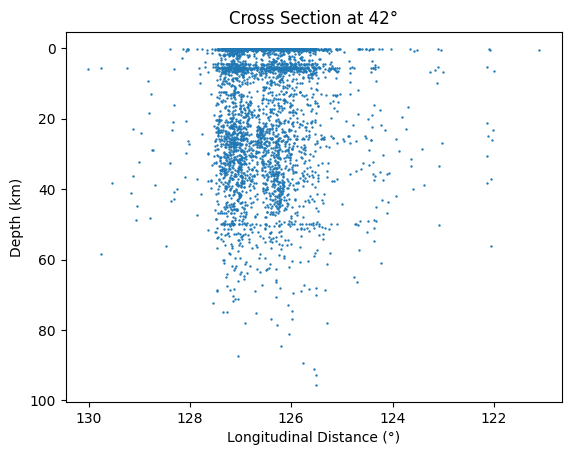

In [48]:
exact_lat = 42 # the exact latitude that you want the cross section to be at
deg = 0.5
events = events_hpy 
events_lat = events.loc[(events['LAT']>exact_lat-deg)&(events['LAT']<exact_lat+deg)]
lon = list(events_lat['LON'].sort_values(ascending=True))
depth = events_lat['DEPTH']
dist = []
for i in lon:
    dist1 = degrees2kilometers(i-lon[0])
    dist.append(abs(dist1))
    print(i,lon[0],abs(dist1))

plt.figure()
plt.scatter(lon,depth,0.5)
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.xlabel('Longitudinal Distance (\xb0)')
plt.ylabel('Depth (km)')
plt.title(f'Cross Section at {exact_lat}\xb0')

## Run HypoDD

### Convert the Hypoinverse output to a phase file

In [3]:
import datetime
import math
import sys
import os
region = 'pnsn_jdf'
def format_convert(phaseinput,phaseoutput):

    g = open(phaseoutput, 'w')
    nn = 100000

    with open(phaseinput, "r") as f:
        for line in f:
            if (len(line) == 180):
                iok = 0
                RMS = float(line[48:52]) / 100
                gap = int(line[42:45])
                dep = float(line[31:36])/100
                EZ = float(line[89:93])/100
                EH = float(line[85:89])/100

                nn = nn + 1
                year = int(line[0:4])
                mon = int(line[4:6])
                day = int(line[6:8])
                hour = int(line[8:10])
                min = int(line[10:12])
                sec = int(line[12:16])/100

                if line[18] == ' ': #N
                    lat = (float(line[16:18]) + float(line[19:23]) / 6000)
                else:
                    lat = float(line[16:18]) + float(line[19:23])/6000 * (-1)

                if line[26] == 'E':
                    lon = (float(line[23:26]) + float(line[27:31]) / 6000)
                else:
                    lon = (float(line[23:26]) + float(line[27:31]) / 6000) * (-1)

                mag = float(line[123:126])/100
                g.write(
                    '# {:4d} {:2d} {:2d} {:2d} {:2d} {:5.2f}  {:7.4f} {:9.4f}   {:5.2f} {:5.2f} {:5.2f} {:5.2f} {:5.2f} {:9d} E\n'.format(
                        year, mon, day, hour, min, sec, lat, lon, dep, mag, EH, EZ, RMS, nn))
                iok = 1
            else:
                if (iok == 1 and len(line) == 121):
                    station = line[0:5]
                    net = line[5:7]
                    chn = line[9:11]
                    year1 = int(line[17:21])
                    mon1 = int(line[21:23])
                    day1 = int(line[23:25])
                    hour1 = int(line[25:27])
                    min1 = int(line[27:29])

                    if year1 == year and mon1 == mon and day1 == day and hour1 == hour and min1 == min:
                        sec_p =sec
                        if line[13:15] == ' P' or line[13:15] == 'IP':
                            P_residual = abs(int(line[34:38]) / 100)
                            sec_p = int(line[29:34]) / 100
                            ppick = sec_p-sec
                            
                            g.write('{:<2s}{:<5s}    {:8.3f}   1.000   P {:<2s} \n'.format(net, station, ppick,chn))

                        if line[46:48] == ' S' or line[46:48] == 'ES':
                            S_residual = abs(int(line[50:54]) / 100)
                            sec_s = int(line[41:46]) / 100
                            spick = sec_s-sec
                            
                            g.write('{:<2s}{:<5s}    {:8.3f}   1.000   S {:<2s} \n'.format(net, station, spick,chn))
    f.close()
    g.close()

%cd /home/hbito/cascadia_obs_ensemble/
input_file = f'./hypoInv/hypoOut_{region}.arc'
Path('./hypodd/results_hypodd').mkdir(parents=True, exist_ok=True)
output_file = f'./hypodd/results_hypodd/hypoDD_{region}.pha'
format_convert(input_file, output_file)
print('phase file:', output_file)
%cp ./workflow_pnsn_jdf/stations_hypoDD_pnsn_jdf.dat ./hypodd/results_hypodd/.


/home/jupyter_share/miniconda3/envs/seismo/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/home/hbito/cascadia_obs_ensemble
phase file: ./hypodd/results_hypodd/hypoDD_pnsn_jdf.pha


### Make a time difference file 

In [11]:
%cd /home/hbito/cascadia_obs_ensemble/hypodd/results_hypodd/
%pwd
!ph2dt ph2dt.inp

/home/hbito/cascadia_obs_ensemble/hypodd/results_hypodd


3976.07s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


starting ph2dt (v1.3 - 08/2010)...                               

reading data ...
 > stations =           77
 > events total =        23253
 > events selected =        11787
 > phases =       142024
forming dtimes...
 > P-phase pairs total =       597736
 > S-phase pairs total =       879241
 > outliers =        12498  (           0 %)
 > phases at stations not in station list =            0
 > phases at distances larger than MAXDIST =       173419
 > P-phase pairs selected =       274190  (          45 %)
 > S-phase pairs selected =       358770  (          40 %)
 > weakly linked events =         9067  (          76 %)
 > linked event pairs =        65700
 > average links per pair =            9
 > average offset (km) betw. linked events =    7.02529764    
 > average offset (km) betw. strongly linked events =    7.26415682    
 > maximum offset (km) betw. strongly linked events =    11.9999924    

Done.                           

Output files: dt.ct; event.dat; event.sel; ph2dt.l

In [1]:
!hypoDD hypoDD_pnsn_jdf.inp

starting hypoDD (v1.3 - 11/2010)...          Thu Dec 19 10:16:26 2024
STOP  >>> ERROR OPENING INPUT PARAMETER FILE.
